In [1]:
import pandas as pd
from datasets import DatasetDict, Dataset, load_from_disk
import os

#os.environ['WANDB_DISABLED'] = 'true'

dataset_path = '../bin/multirc_dataset.hf'
seed = 42

In [2]:
df = pd.read_csv('../data/multirc.csv')#[['source_text', 'source_text_clean', 'question_text', 'answer_text', 'is_correct']]
def clean_df(df):
    df['labels'] = df['is_correct'].apply(lambda x: str(x))
    df['answer_text'] = df['answer_text'].apply(lambda x: str(x))
    df['comp'] = "### Instructions \nYou will be provided with a text, a question, and an answer. Your task is to decide whether the answer is correct or incorrect and respond with a single word denoting the appropriate label: `False` for incorrect and `True` for correct.\n\n\n###The text\nThe text is as follows, delimited by three backticks: ```" + df['source_text_clean'] + "...```\n\n\n ### The question and answer pair \n The question and answer pair are as follows, delimited by three backticks: ```##Question: " + df["question_text"] + " ##Answer: " + df['answer_text'] + "``` "
    df['text'] = df['comp'] + "\n\n\n<<<" + df['labels'] + ">>>"
    df = df[['comp', 'labels', 'text']]

     
    return df.reset_index()
    return df

In [3]:
from sklearn.model_selection import train_test_split
source_index = df['source_text'].drop_duplicates()
train_index, validtest_index = train_test_split(source_index, test_size=0.3,train_size=0.7, random_state = seed)
valid_index, test_index = train_test_split(validtest_index, test_size=0.5, train_size=0.5, random_state = seed)

train_df = clean_df(df[df['source_text'].isin(train_index)].dropna())[['comp', 'labels', 'text']]
valid_df = clean_df(df[df['source_text'].isin(valid_index)].dropna())[['comp', 'labels', 'text']]
test_df = clean_df(df[df['source_text'].isin(test_index)].dropna())[['comp', 'labels', 'text']]

print(len(train_df))
print(len(valid_df))
print(len(test_df))

19170
4080
3962


In [7]:
# testing to make sure the datasets are properly partitioned

repetitions = 0
for i in train_df['text']:
    repetitions += valid_df['text'].isin([i]).sum()

print(repetitions)

0


In [8]:
ds = DatasetDict()
ds['train'] = Dataset.from_pandas(train_df, preserve_index=False)
ds['valid'] = Dataset.from_pandas(valid_df, preserve_index=False)
ds['test'] = Dataset.from_pandas(test_df, preserve_index=False)

## Train Llama

In [6]:
from transformers import AutoModelForSequenceClassification, AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer, TrainingArguments, LlamaTokenizer
import transformers
import torch
from peft import LoraConfig
from trl import SFTTrainer
import evaluate
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PromptEncoderConfig,
)
import torch

In [7]:
base_model_name = "ehartford/dolphin-llama2-7b"

In [8]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

device_map = {"": 0}

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map=device_map,
)
base_model.config.use_cache = False

# More info: https://github.com/huggingface/transformers/pull/24906
base_model.config.pretraining_tp = 1 

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.06,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
)

tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

output_dir = "./results"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    logging_steps=100,
    max_steps=1250,
    evaluation_strategy='steps',
    eval_steps=100
    
)

max_seq_length = 2046

In [ ]:
for en, i in enumerate(ds['train']['text']):
    if type(i) != str:
        print(i)
        print(en)

In [12]:
trainer = SFTTrainer(
    model=base_model,
    train_dataset=ds['train'],
    eval_dataset=ds['valid'],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_args,
)

trainer.train()


/home/jovyan/conda_envs/wes_env/lib/python3.11/site-packages/peft/utils/other.py:122: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/19170 [00:00<?, ? examples/s]

/home/jovyan/conda_envs/wes_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: ERROR API key must be 40 characters long, yours was 10
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,2.877500
20,2.178100
30,1.912400
40,1.799200
50,1.740500
60,1.728100
70,1.660700
80,1.713800
90,1.643500
100,1.583000


TrainOutput(global_step=1250, training_loss=0.647819612121582, metrics={'train_runtime': 37393.0455, 'train_samples_per_second': 0.535, 'train_steps_per_second': 0.033, 'total_flos': 2.933509057383137e+17, 'train_loss': 0.647819612121582, 'epoch': 1.04})

In [13]:
trainer.model.save_pretrained('multirc-llama')

In [ ]:
from peft import AutoPeftModelForCausalLM
import torch
from transformers import AutoTokenizer
device_map = {"": 0}
model_m = AutoPeftModelForCausalLM.from_pretrained("multirc-llama", device_map=device_map, torch_dtype=torch.bfloat16)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name, padding=True)
tokenizer.pad_token = tokenizer.eos_token

In [11]:
import torch
import gc
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
results = []
counter = 0
for text in ds['test']['comp']:
    print('Processing item ' +str(counter)+ ' of ' + str(len(ds['test']['comp'])), end = '\r')
    inputs = tokenizer(text, return_tensors='pt').to(device)
    outputs = model_m.generate(input_ids=inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'], max_new_tokens=1700, pad_token_id=tokenizer.eos_token_id)
    res = tokenizer.decode(outputs[0], skip_special_tokens=True)
    results.append(res)
    counter += 1

In [ ]:
results

In [ ]:
test_df['raw_results'] = results
test_df['clean_results'] = test_df['raw_results'].apply(lambda x: x.replace(text,""))
test_df.to_csv('test_df.csv')

'### Instructions \nYou will be provided with a text, a question, and an answer. Your task is to decide whether the answer is correct or incorrect and respond with a single word denoting the appropriate label: `False` for incorrect and `True` for correct.\n\n\n###The text\nThe text is as follows, delimited by three backticks: ```Legal assistance for battered women is hard to come by.\nBut it just got a little easier to find in Tarrant County.\nThis month, the federal Violence Against Women Office awarded a two-year, $350,000 grant to the Women\'s Haven of Tarrant County.\nThe money will allow the shelter to add a second full-time attorney to its staff and contract with the law school clinic at Texas Wesleyan University for pro bono and student services.\nMost important, the funds will help fill a frustrating gap.\nThe Women\'s Haven, which provides shelter and outreach to domestic-violence victims, already has a full-time attorney.\nBut that person is prohibited (by funding parameters)

In [14]:
# testing

text = ds['test']['comp'][1]
print(text)

inputs = tokenizer(text, return_tensors='pt').to(device)
outputs = model_m.generate(input_ids=inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'], max_new_tokens=1700, pad_token_id=tokenizer.eos_token_id)
res = tokenizer.decode(outputs[0], skip_special_tokens=True)#.replace(text,"")
print(res)
# results.append(res)

### Instructions 
You will be provided with a text, a question, and an answer. Your task is to decide whether the answer is correct or incorrect and respond with a single word denoting the appropriate label: `False` for incorrect and `True` for correct.


###The text
The text is as follows, delimited by three backticks: ```Legal assistance for battered women is hard to come by.
But it just got a little easier to find in Tarrant County.
This month, the federal Violence Against Women Office awarded a two-year, $350,000 grant to the Women's Haven of Tarrant County.
The money will allow the shelter to add a second full-time attorney to its staff and contract with the law school clinic at Texas Wesleyan University for pro bono and student services.
Most important, the funds will help fill a frustrating gap.
The Women's Haven, which provides shelter and outreach to domestic-violence victims, already has a full-time attorney.
But that person is prohibited (by funding parameters) from represen

In [9]:
def parse_output(text):
    text = str(text)
    if text.find('True>') >  -1:
        return 'True'
    elif text.find('False>') > -1:
        return 'False'
    else:
        return np.nan


import numpy as np
import pandas as pd
results_df = pd.read_csv('test_df.csv')
results_df['preds'] = results_df['raw_results'].apply(lambda x: parse_output(x))

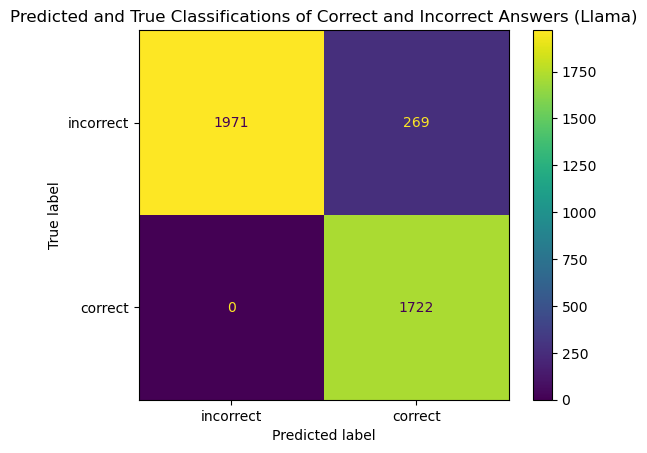

In [15]:
from sklearn import metrics
from matplotlib import pyplot as plt

results_df['labels'] = results_df['labels'].apply(lambda x: str(x))

confusion_matrix = metrics.confusion_matrix(results_df['labels'], results_df['preds'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['incorrect', 'correct'])

cm_display.plot()
plt.title('Predicted and True Classifications of Correct and Incorrect Answers (Llama)')
plt.show()

In [16]:
print(metrics.classification_report(results_df['labels'], results_df['preds']))

              precision    recall  f1-score   support

       False       1.00      0.88      0.94      2240
        True       0.86      1.00      0.93      1722

    accuracy                           0.93      3962
   macro avg       0.93      0.94      0.93      3962
weighted avg       0.94      0.93      0.93      3962



In [ ]:
textbook_df = pd.read_csv()